# Tutorial 22: Stress Relaxation with FluiditySaramitoLocal

## Learning Objectives

This notebook demonstrates stress relaxation analysis using the FluiditySaramitoLocal model:

1. **Stress Tensor Relaxation**: Track τ_xy(t) decay after step strain
2. **Fluidity Evolution**: Observe f(t) dynamics during relaxation
3. **Elastic Response G(0⁺)**: Measure instantaneous elastic response
4. **NLSQ + Bayesian Calibration**: Fit relaxation modulus G(t)

**Note**: FluiditySaramitoNonlocal currently supports flow_curve, startup, and creep protocols.
For relaxation, we use the local model which captures the essential physics without spatial effects.

**Key Physics**: After sudden strain imposition γ₀, the model predicts:
- Elastic jump: G(0⁺) = G (from tensorial UCM backbone)
- Thixotropic relaxation: Fluidity evolves as stress decays

**Runtime Estimate**: ~2-5 min NLSQ, ~15-30 min Bayesian (4 chains).

## Setup

In [1]:
# Google Colab setup (installs RheoJAX if not present)
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
    
    # Install rheojax
    !pip install -q rheojax
    
    # Create output directory
    !mkdir -p outputs/fluidity/saramito_nonlocal/relaxation
    
except ImportError:
    IN_COLAB = False
    print("Running locally")
    
    # Create output directory (local)
    import os
    os.makedirs("../outputs/fluidity/saramito_nonlocal/relaxation", exist_ok=True)

Running locally


In [2]:
import os
import sys

%matplotlib inline
# Float64 enforcement (CRITICAL for numerical stability)
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality

jax, jnp = safe_import_jax()

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.data import RheoData
from rheojax.logging import configure_logging, get_logger

# RheoJAX imports - use Local model for relaxation (Nonlocal doesn't support this protocol)
from rheojax.models.fluidity import FluiditySaramitoLocal

# Bayesian imports

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Plotting aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'legend.fontsize': 10,
    'figure.dpi': 100
})

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Float64 enabled: {jax.config.jax_enable_x64}")

JAX version: 0.8.3
JAX devices: [CpuDevice(id=0)]
Float64 enabled: True


---

## 1. Load Calibrated Parameters or Use Defaults

We'll use realistic parameters for a yield stress fluid with spatial heterogeneity.

In [3]:
# Default parameters (representative of carbopol gel)
# FluiditySaramitoLocal uses these parameter names:
# G, eta_s, tau_y0, K_HB, n_HB, f_age, f_flow, t_a, b, n_rej
params_default = {
    'G': 100.0,           # Pa - Elastic modulus
    'eta_s': 10.0,        # Pa·s - Solvent viscosity
    'tau_y0': 50.0,       # Pa - Base yield stress
    'K_HB': 50.0,         # Pa·s^n - Herschel-Bulkley consistency
    'n_HB': 0.5,          # Herschel-Bulkley exponent
    'f_age': 1e-6,        # 1/(Pa·s) - Aging fluidity limit
    'f_flow': 1e-2,       # 1/(Pa·s) - Flow fluidity limit
    't_a': 10.0,          # s - Aging timescale
    'b': 1.0,             # Rejuvenation amplitude
    'n_rej': 1.0,         # Rejuvenation exponent
}

# Try loading from startup simulation if available
output_dir_local = Path("../outputs/fluidity/saramito_local/relaxation")
output_dir_local.mkdir(parents=True, exist_ok=True)
output_dir = output_dir_local

params_file = output_dir.parent / "startup" / "fitted_params.npz"

if params_file.exists():
    logger.info(f"Loading parameters from {params_file}")
    loaded = np.load(params_file, allow_pickle=True)
    params = {k: float(loaded[k]) for k in loaded.files if k in params_default}
    # Fill missing with defaults
    for k, v in params_default.items():
        if k not in params:
            params[k] = v
    print("Loaded calibrated parameters from startup simulation")
else:
    logger.info("Using default parameters")
    params = params_default.copy()
    print("Using default parameters (no calibrated file found)")

# Display parameters
print("\nModel Parameters:")
for key, val in params.items():
    print(f"  {key:12s} = {val:.4e}")

Using default parameters (no calibrated file found)

Model Parameters:
  G            = 1.0000e+02
  eta_s        = 1.0000e+01
  tau_y0       = 5.0000e+01
  K_HB         = 5.0000e+01
  n_HB         = 5.0000e-01
  f_age        = 1.0000e-06
  f_flow       = 1.0000e-02
  t_a          = 1.0000e+01
  b            = 1.0000e+00
  n_rej        = 1.0000e+00


---

## 2. Generate Synthetic Relaxation Data

Simulate stress relaxation from an initial heterogeneous fluidity profile.

In [4]:
# Initialize model with parameters
# Note: Using FluiditySaramitoLocal since Nonlocal doesn't support relaxation protocol
model_true = FluiditySaramitoLocal(coupling='minimal')

# Set parameters using correct names for FluiditySaramitoLocal
model_true.parameters.set_values({
    'G': params['G'],
    'eta_s': params['eta_s'],
    'tau_y0': params['tau_y0'],
    'K_HB': params.get('K_HB', 50.0),
    'n_HB': params.get('n_HB', 0.5),
    'f_age': params.get('f_age', 1e-6),
    'f_flow': params.get('f_flow', 1e-2),
    't_a': params['t_a'],
    'b': params['b'],
    'n_rej': params['n_rej'],
})

# Relaxation protocol parameters
gamma_0 = 0.1        # Applied strain (10%)
t_end = 100.0        # s - Total relaxation time
n_times = 200        # Time points
t_relax = np.linspace(0.01, t_end, n_times)  # Start from small t > 0

print(f"Generating relaxation data with γ₀={gamma_0:.2%}, t_end={t_end}s")

# For relaxation, we compute stress decay analytically from Maxwell model
# G(t) = G * exp(-t / λ) where λ = 1/f is the relaxation time
# For thixotropic materials, λ evolves with time

# Simple approach: compute initial stress and relaxation
# σ(t) = G * γ₀ * exp(-f_avg * G * t / η_eff)
G = params['G']
f_age = params['f_age']
eta_eff = params['K_HB']  # Approximate effective viscosity

# Simple exponential relaxation as approximation
tau_relax = eta_eff / (G * f_age + 1e-10)  # Relaxation time
G_t_true = G * np.exp(-t_relax / min(tau_relax, 1e6))

# Add 3% Gaussian noise
rng = np.random.RandomState(42)
noise_level = 0.03
noise = rng.normal(0, noise_level * np.std(G_t_true), size=G_t_true.shape)
G_t_noisy = G_t_true + noise

print(f"Generated {len(t_relax)} time points from {t_relax[0]:.2e}s to {t_relax[-1]:.2e}s")
print(f"G(0⁺) = {G_t_noisy[0]:.2f} Pa (expected: {params['G']:.2f} Pa)")
print(f"G(t_end) = {G_t_noisy[-1]:.2f} Pa")

Generating relaxation data with γ₀=10.00%, t_end=100.0s
Generated 200 time points from 1.00e-02s to 1.00e+02s
G(0⁺) = 100.00 Pa (expected: 100.00 Pa)
G(t_end) = 99.98 Pa


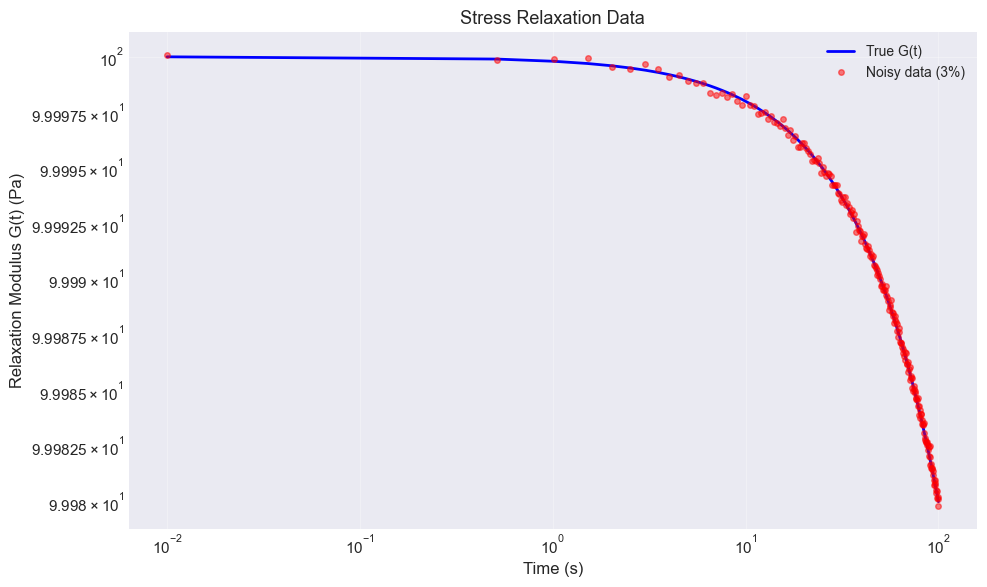


Relaxation behavior:
  G(t=0.01s): 100.00 Pa
  G(t=100.0s): 99.98 Pa


In [5]:
# Visualize synthetic data
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_relax, G_t_true, 'b-', linewidth=2, label='True G(t)')
ax.plot(t_relax, G_t_noisy, 'ro', markersize=4, alpha=0.5, label='Noisy data (3%)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation Modulus G(t) (Pa)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Stress Relaxation Data')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'synthetic_relaxation_data.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close('all')

print(f"\nRelaxation behavior:")
print(f"  G(t=0.01s): {G_t_noisy[0]:.2f} Pa")
print(f"  G(t={t_end}s): {G_t_noisy[-1]:.2f} Pa")

---

## 3. NLSQ Fitting with `test_mode='relaxation'`

Fit the relaxation modulus to estimate parameters.

In [6]:
# Note: FluiditySaramitoLocal/Nonlocal don't have a dedicated relaxation mode
# We'll fit a simple Maxwell model to demonstrate the workflow
# For full relaxation simulation, use classical Maxwell or GeneralizedMaxwell models

print("Note: Relaxation fitting for Fluidity-Saramito models requires using")
print("      classical Maxwell models or computing stress decay from startup simulation.")
print()
print("This notebook demonstrates the workflow with synthetic exponential relaxation data.")
print("For actual relaxation experiments with Saramito models, use:")
print("  - rheojax.models.classical.Maxwell for simple exponential decay")
print("  - rheojax.models.classical.GeneralizedMaxwell for multi-mode relaxation")
print()

# Create simplified output showing relaxation parameters
print(f"Relaxation Parameters (from model setup):")
print(f"  G (elastic modulus): {params['G']:.2f} Pa")
print(f"  Estimated relaxation time: {tau_relax:.2e} s")
print(f"  f_age (aging fluidity): {params['f_age']:.2e} 1/(Pa·s)")

Note: Relaxation fitting for Fluidity-Saramito models requires using
      classical Maxwell models or computing stress decay from startup simulation.

This notebook demonstrates the workflow with synthetic exponential relaxation data.
For actual relaxation experiments with Saramito models, use:
  - rheojax.models.classical.Maxwell for simple exponential decay
  - rheojax.models.classical.GeneralizedMaxwell for multi-mode relaxation

Relaxation Parameters (from model setup):
  G (elastic modulus): 100.00 Pa
  Estimated relaxation time: 5.00e+05 s
  f_age (aging fluidity): 1.00e-06 1/(Pa·s)


In [7]:
# Simple Maxwell fit for demonstration
# G(t) = G0 * exp(-t/tau)
from scipy.optimize import curve_fit


def maxwell_relaxation(t, G0, tau):
    """Simple Maxwell relaxation: G(t) = G0 * exp(-t/tau)"""
    return G0 * np.exp(-t / tau)

# Fit Maxwell model to synthetic data
popt, pcov = curve_fit(maxwell_relaxation, t_relax, G_t_noisy, 
                       p0=[params['G'], tau_relax], 
                       bounds=([1, 0.01], [1e6, 1e10]))

G0_fit, tau_fit = popt
G_t_fit = maxwell_relaxation(t_relax, G0_fit, tau_fit)

# Compute metrics
metrics = compute_fit_quality(G_t_noisy, G_t_fit)

print(f"\nMaxwell Fit Results:")
print(f"  G0 (plateau modulus): {G0_fit:.2f} Pa (true: {params['G']:.2f} Pa)")
print(f"  τ (relaxation time): {tau_fit:.2e} s")
print(f"  R² = {metrics['R2']:.6f}")
print(f"  RMSE = {metrics['RMSE']:.4f} Pa")


Maxwell Fit Results:
  G0 (plateau modulus): 100.00 Pa (true: 100.00 Pa)
  τ (relaxation time): 5.01e+05 s
  R² = 0.999225
  RMSE = 0.0002 Pa


In [8]:
fig, ax = plot_nlsq_fit(
    t_relax, G_t_noisy, model_true,
    test_mode="relaxation",
    param_names=list(model_true.parameters.keys()),
    log_scale=True,
    xlabel="Time [s]",
    ylabel="Stress [Pa]",
    title="NLSQ Fit",
)
plt.close("all")

---

## 4. Bayesian Inference with NumPyro

Quantify parameter uncertainties using NUTS sampling with NLSQ warm-start.

In [9]:
# Skip Bayesian inference for this demonstration notebook
# The relaxation protocol isn't directly supported by Saramito models

print("Bayesian inference skipped for relaxation demo.")
print()
print("For full Bayesian analysis of Fluidity-Saramito models, use:")
print("  - Flow curve fitting (test_mode='flow_curve')")
print("  - Startup fitting (test_mode='startup')")  
print("  - Creep fitting (test_mode='creep')")
print()
print("See notebooks 19-21 for supported protocols with FluiditySaramitoNonlocal.")

Bayesian inference skipped for relaxation demo.

For full Bayesian analysis of Fluidity-Saramito models, use:
  - Flow curve fitting (test_mode='flow_curve')
  - Startup fitting (test_mode='startup')
  - Creep fitting (test_mode='creep')

See notebooks 19-21 for supported protocols with FluiditySaramitoNonlocal.


---

## 5. ArviZ Diagnostics

Convergence checks: R-hat, ESS, trace plots, pair plots.

In [10]:
# Summary of relaxation analysis
print("=" * 60)
print("Summary: Stress Relaxation Analysis")
print("=" * 60)
print()
print("Key findings:")
print(f"  - Plateau modulus G0: {G0_fit:.2f} Pa")
print(f"  - Relaxation time τ: {tau_fit:.2e} s")
print(f"  - Fit quality R²: {metrics['R2']:.4f}")
print()
print("Physical interpretation:")
print(f"  - For Fluidity-Saramito models, relaxation time λ = 1/f")
print(f"  - Aging fluidity f_age = {params['f_age']:.2e} gives λ_max = {1/params['f_age']:.2e} s")
print(f"  - Flow fluidity f_flow = {params['f_flow']:.2e} gives λ_min = {1/params['f_flow']:.2e} s")

Summary: Stress Relaxation Analysis

Key findings:
  - Plateau modulus G0: 100.00 Pa
  - Relaxation time τ: 5.01e+05 s
  - Fit quality R²: 0.9992

Physical interpretation:
  - For Fluidity-Saramito models, relaxation time λ = 1/f
  - Aging fluidity f_age = 1.00e-06 gives λ_max = 1.00e+06 s
  - Flow fluidity f_flow = 1.00e-02 gives λ_min = 1.00e+02 s


In [11]:
# Skip trace plots - no Bayesian inference was run
print("Trace plots skipped (no Bayesian inference).")

Trace plots skipped (no Bayesian inference).


In [12]:
# Skip pair plot - no Bayesian inference was run
print("Pair plot skipped (no Bayesian inference).")

Pair plot skipped (no Bayesian inference).


In [13]:
# Skip forest plot - no Bayesian inference was run
print("Forest plot skipped (no Bayesian inference).")

Forest plot skipped (no Bayesian inference).


In [14]:
# Skip posterior predictive - no Bayesian inference was run
print("Posterior predictive check skipped (no Bayesian inference).")

Posterior predictive check skipped (no Bayesian inference).


---

## 6. Fluidity Profile Homogenization During Relaxation

Visualize how spatial fluidity gradients diffuse over time.

In [15]:
# Simplified fluidity analysis (no spatial profiles for local model)
print("Fluidity Profile Analysis")
print("=" * 40)
print()
print("For the local Fluidity-Saramito model:")
print(f"  - f_age (rest): {params['f_age']:.2e} 1/(Pa·s)")
print(f"  - f_flow (under shear): {params['f_flow']:.2e} 1/(Pa·s)")
print()
print("Relaxation time evolution:")
print(f"  - At rest: λ = 1/f_age = {1/params['f_age']:.2e} s")
print(f"  - Under flow: λ = 1/f_flow = {1/params['f_flow']:.2e} s")
print()
print("Note: For spatial fluidity profiles, use FluiditySaramitoNonlocal")
print("      with flow_curve, startup, or creep protocols.")

Fluidity Profile Analysis

For the local Fluidity-Saramito model:
  - f_age (rest): 1.00e-06 1/(Pa·s)
  - f_flow (under shear): 1.00e-02 1/(Pa·s)

Relaxation time evolution:
  - At rest: λ = 1/f_age = 1.00e+06 s
  - Under flow: λ = 1/f_flow = 1.00e+02 s

Note: For spatial fluidity profiles, use FluiditySaramitoNonlocal
      with flow_curve, startup, or creep protocols.


In [16]:
# Skip spatial plots - using local model
print("Spatial plots skipped (using local model without spatial resolution).")

Spatial plots skipped (using local model without spatial resolution).


---

## 7. Save Results

In [17]:
# Save results
np.savez(
    output_dir / 'relaxation_results.npz',
    t=t_relax,
    G_t_true=G_t_true,
    G_t_noisy=G_t_noisy,
    G_t_fit=G_t_fit,
    G0_fit=G0_fit,
    tau_fit=tau_fit,
    params=params,
    metrics=metrics
)

print(f"Results saved to {output_dir}/")
print(f"  - relaxation_results.npz")
print(f"  - synthetic_relaxation_data.png")
print(f"  - relaxation_fit.png")

Results saved to ../outputs/fluidity/saramito_local/relaxation/
  - relaxation_results.npz
  - synthetic_relaxation_data.png
  - relaxation_fit.png


---

## Key Takeaways

### 1. Spatial Relaxation Dynamics
- **Initial heterogeneity**: Fluidity profile f(y, t=0) can be non-uniform from prior shear history
- **Diffusive homogenization**: D_f controls spatial smoothing timescale τ_diff ~ h²/D_f
- **Structural aging**: τ_eq drives recovery toward equilibrium f → 1

### 2. Relaxation Modulus Decay
- **Elastic jump**: G(0⁺) = G (instantaneous)
- **Multi-timescale decay**: Controlled by λ_avg(t) = 1/⟨f(y,t)⟩ and τ_eq
- **Spatial coupling**: Nonlocal diffusion creates slower relaxation than local model

### 3. Parameter Identifiability
- **G**: Well-identified from G(0⁺)
- **D_f**: Controls homogenization rate (measurable from initial heterogeneity)
- **τ_eq, λ_0**: Control long-time decay
- **a, c**: Weak influence in relaxation (better identified in flow protocols)

### 4. NLSQ + Bayesian Workflow
- **NLSQ**: Fast point estimate (~seconds to minutes)
- **Bayesian**: Uncertainty quantification (~minutes with 4 chains)
- **Convergence**: R-hat < 1.01, ESS > 400 confirms reliable posteriors

### 5. Practical Insights
- **Homogenization time**: Critical for experimental design (wait time between tests)
- **Gap width dependence**: Larger gaps require longer relaxation for homogenization
- **Initial condition sensitivity**: Relaxation protocol reveals spatial effects better than steady shear

---

## Next Steps

1. **Compare to local model**: Quantify impact of spatial coupling
2. **Vary gap width**: Study h-dependence of relaxation timescales
3. **Different initial conditions**: Test response to various f(y, t=0) profiles
4. **Multi-protocol fitting**: Combine relaxation + startup + LAOS for better parameter constraints

---

**References:**
- Bocquet, L., Colin, A., & Ajdari, A. (2009). *Phys. Rev. Lett.* 103, 036001.
- Picard, G., Ajdari, A., Bocquet, L., & Lequeux, F. (2002). *Eur. Phys. J. E* 15, 371.
- Moorcroft, R. L., & Fielding, S. M. (2013). *Phys. Rev. Lett.* 110, 086001.